# BOMEX Cloud Field Properties

Here's a quick Gaussian Process (GP) analysis for a high-resolution BOMEX LES model run. The model domain size was 38.4 km $\times$ 12.8 km $\times$ 4.8 km at 25 m resolution. 

In [2]:
import os, glob

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns

import xarray as xr
import numpy as np

from pathlib import Path

In [3]:
case = 'BOMEX_SWAMP'

# Path
src = Path(f'/Howard16TB/data/loh/{case}')
stat = next(src.glob('*.nc'))

# Mean Cloud Field Statistics
## Cloud Fraction

<xarray.DataArray 'CLDSHD' (time: 780)>
array([0.20998 , 0.211223, 0.212639, ..., 0.237994, 0.238434, 0.239188],
      dtype=float32)
Coordinates:
  * time     (time) float32 180.12535 180.12604 ... 180.66562 180.66632
Attributes:
    long_name:  Shaded Cloud Fraction
    units:      


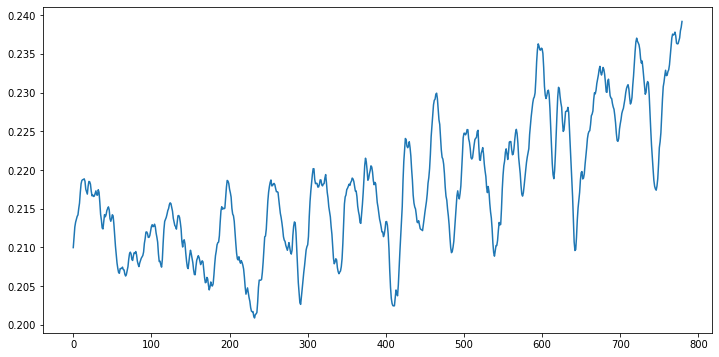

In [4]:
with xr.open_dataset(stat) as sf:
    var = sf.CLDSHD[180:960]
    
print(var)

plt.plot(var)
plt.show()

 Detrend using Kernel regression method

In [5]:
from statsmodels.nonparametric import smoothers_lowess as sl

from sklearn import linear_model as lm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels as kern

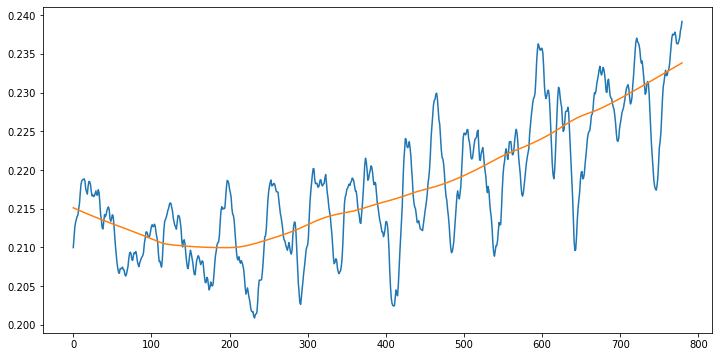

In [6]:
X = np.arange(len(var))
Y = np.array(var)

Y_ = sl.lowess(Y, X, return_sorted=False, frac=.3)

plt.plot(X, Y)
plt.plot(X, Y_)
plt.show()

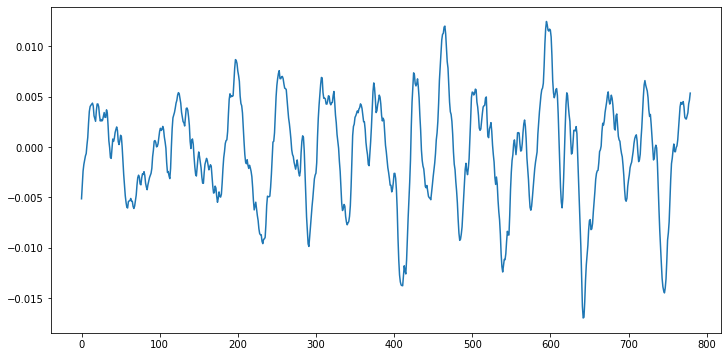

In [7]:
# Take detrended time series
Y = Y - Y_

plt.plot(X, Y)
plt.show()

In [8]:
# Define GP kernel
kernel =  1.0 * kern.RBF(length_scale_bounds=(1e3, 1e5)) \
        + 1.0 * kern.WhiteKernel(noise_level=1) \
        + 1.0 * kern.ExpSineSquared(
                    length_scale=1e2,
                    length_scale_bounds=(1, 1e3),
                    periodicity=80,
                    periodicity_bounds=(75, 85)
                ) \
        + 1.0 * kern.ExpSineSquared(
                    length_scale=1e2,
                    length_scale_bounds=(1, 1e3),
                    periodicity=45,
                    periodicity_bounds=(35, 45)
                )

gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5)

# Fit GP regressor 
gp.fit(X[:, None], Y[:])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + 1**2 * WhiteKernel(noise_level=1) + 1**2 * ExpSineSquared(length_scale=100, periodicity=80) + 1**2 * ExpSineSquared(length_scale=100, periodicity=45),
                         n_restarts_optimizer=5, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

0.00316**2 * RBF(length_scale=9.97e+04) + 0.044**2 * WhiteKernel(noise_level=0.0104) + 0.00321**2 * ExpSineSquared(length_scale=1, periodicity=82.7) + 0.00352**2 * ExpSineSquared(length_scale=2.94, periodicity=42.8)
3.9687054814084113


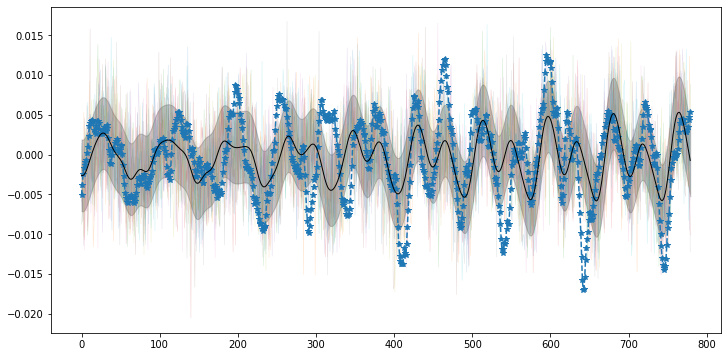

In [9]:
plt.plot(X[:], Y[:], '--*', zorder=9)

y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X[:], y_mean[:], 'k', lw=1, zorder=9)
plt.fill_between(X[:], y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_ / len(X[:]))

y_samples = gp.sample_y(X[:, None], 10)
plt.plot(X[:], y_samples, lw=0.5, alpha=0.2)
plt.show()

## Precipitative flux

<xarray.DataArray 'PRECIP' (time: 440)>
array([0.66519 , 0.675536, 0.689064, ..., 0.943518, 0.932813, 0.920715],
      dtype=float32)
Coordinates:
  * time     (time) float32 180.36145 180.36215 ... 180.66562 180.66632


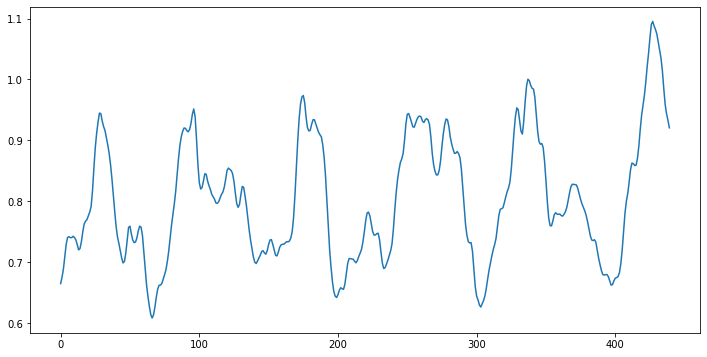

In [18]:
with xr.open_dataset(stat) as sf:
    var = np.sum(sf.PRECIP[520:960], axis=1)
    
print(var)

plt.plot(var)
plt.show()

In [19]:
X = np.arange(len(var))
Y = np.array(var)

Y = Y - sl.lowess(Y, X, return_sorted=False, frac=.3)

In [20]:
# Define GP kernel
kernel =  1.0 * kern.RBF(length_scale_bounds=(1e3, 1e5)) \
        + 1.0 * kern.WhiteKernel(noise_level=1) \
        + 1.0 * kern.ExpSineSquared(
                    length_scale=1e2,
                    length_scale_bounds=(10, 1e3),
                    periodicity=80,
                    periodicity_bounds=(65, 95)
                ) \
        + 1.0 * kern.ExpSineSquared(
                    length_scale=1e2,
                    length_scale_bounds=(10, 1e3),
                    periodicity=45,
                    periodicity_bounds=(25, 55)
                )

gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=2)

# Fit GP regressor 
gp.fit(X[:, None], Y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + 1**2 * WhiteKernel(noise_level=1) + 1**2 * ExpSineSquared(length_scale=100, periodicity=80) + 1**2 * ExpSineSquared(length_scale=100, periodicity=45),
                         n_restarts_optimizer=2, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

0.00602**2 * RBF(length_scale=7.24e+03) + 0.0264**2 * WhiteKernel(noise_level=7.76) + 1.46**2 * ExpSineSquared(length_scale=10, periodicity=79.6) + 0.256**2 * ExpSineSquared(length_scale=10.9, periodicity=34.5)
1.1663105517896732


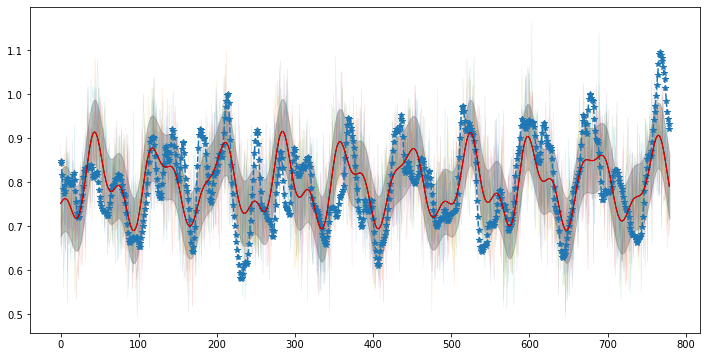

In [13]:
plt.plot(X[:], Y[:], '--*', zorder=9)

y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X[:], y_mean[:], 'k', lw=1, zorder=9)
plt.plot(X[:], y_mean[:], 'r', lw=1, zorder=9)
plt.fill_between(X[:], y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_ / len(X[:]))

y_samples = gp.sample_y(X[:, None], 10)
plt.plot(X[:], y_samples, lw=0.5, alpha=0.2)
plt.show()